

 # 【分析レポート】金利は株価の"重力"か？

 ## 1. 分析の目的

 ウォーレン・バフェットをはじめとする多くの著名な投資家は、「金利は株価にとっての重力のようなものだ」と語る。これは、金利が上昇すれば、将来のキャッシュフローの割引価値が下がり、株価のバリュエーション（割高・割安を示す指標）は低下するはずだ、という理論に基づいている。

 この分析では、この有名なアノマリー（経験則）がデータによって裏付けられるかを検証する。具体的には、**米国10年債利回り（長期金利の代表）**と、景気循環調整後の株価収益率である**S&P 500のシラーPER**という、2つのマクロ経済指標の関係性を、過去約20年間のデータを用いて定量的に分析することを目的とする。

 ## 2. 分析の結論（エグゼクティブ・サマリー）

 驚くべきことに、過去約20年間のデータにおいては、**「金利とシラーPERの間に、統計的に有意な線形の関係性は見られない」**という結論に至った。

 相関係数は-0.036とほぼゼロであり、回帰分析における決定係数（R-squared）も0.001と極めて低かった。これは、金利の動きだけでは、シラーPERの動きをほとんど説明できないことを意味する。

 この結果は、美しい理論や経験則が、常に現実の市場で機能するとは限らないことを示唆している。株価のバリュエーションは、金利という単一の「重力」だけでなく、**企業の利益成長期待**や**投資家心理**といった、他の複数の強力な要因が複雑に絡み合って決定される、より複雑なシステムであると考えられる。



 ## 3. データ準備：異種データの収集と整形

 このマクロ分析の土台となる、3つの異なるソースからのデータを収集・整形する。
 1.  **米国10年債利回り (`DGS10`):** `pandas_datareader`を使い、FRED（セントルイス連邦準備銀行）から取得。
 2.  **S&P 500指数 (`^GSPC`):** `yfinance`から取得。
 3.  **シラーPER:** ロバート・シラー教授が公開しているExcelファイルから直接読み込む。

 これらのデータは更新頻度が異なるため、比較分析を可能にするために全て**「月次データ（月末値）」**にリサンプリングし、日付をキーとして一つのデータフレームに統合する。

In [ ]:
#%% データ収集と準備

import yfinance as yf
import pandas_datareader.data as pdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from datetime import datetime, timedelta
import seaborn as sns
import statsmodels.formula.api as smf
# from fredapi import Fred # fredapiはコメントアウトまたは削除

# 日本語フォント設定
plt.rcParams['font.family'] = 'IPAexGothic'

# 分析期間の設定（過去20年）
end = datetime.today()
start = end - timedelta(days=365*20)

# FRED APIキー設定は不要となるため削除

# 米国10年債利回り（DGS10）データ取得（FRED）
dgs10_data = pdr.DataReader('DGS10', 'fred', start, end)
if not dgs10_data.empty:
    dgs10_series = dgs10_data.iloc[:, 0].squeeze()
    if not isinstance(dgs10_series, pd.Series):
        dgs10_series = pd.Series([dgs10_series], index=[dgs10_data.index[0]]) # 単一値の場合にSeriesに変換
else:
    print("Warning: DGS10 data could not be retrieved or is empty.")
    dgs10_series = pd.Series(dtype=float)
print(f"DEBUG: Type of dgs10_series after init: {type(dgs10_series)}")
print(f"DEBUG: Head of dgs10_series after init:\n{dgs10_series.head()}")

# S&P 500価格データ取得（yfinance）
gspc = yf.download('^GSPC', start=start, end=end)
if not gspc.empty:
    gspc_close_series = gspc['Close'].squeeze()
    if not isinstance(gspc_close_series, pd.Series):
        gspc_close_series = pd.Series([gspc_close_series], index=[gspc.index[0]]) # 単一値の場合にSeriesに変換
else:
    print("Warning: S&P 500 data could not be retrieved or is empty.")
    gspc_close_series = pd.Series(dtype=float)
print(f"DEBUG: Type of gspc_close_series after init: {type(gspc_close_series)}")
print(f"DEBUG: Head of gspc_close_series after init:\n{gspc_close_series.head()}")

# Shillerデータ（ie_data.xls）を読み込む
# 'Data'シートにデータがあると仮定。実際のデータは9行目から始まるため、header=8を設定。
# 必要な列のみを読み込む: Date (A列), Shiller PER (M列)
shiller_df = pd.read_excel(
    'ie_data.xls',
    sheet_name='Data',
    header=8,
    usecols='A,M',
    names=['Date', 'Shiller PER'], # 直接列名を設定
    dtype={'Date': str} # Date列を文字列として読み込む
)

# Date列の文字列をYYYY.MM形式とみなし、日付型に変換
# format='%Y.%m' を明示的に指定
shiller_df['Date'] = pd.to_datetime(shiller_df['Date'], format='%Y.%m', errors='coerce')

# NaNの日付行を削除し、Date列をインデックスに設定
shiller_df = shiller_df.dropna(subset=['Date']).set_index('Date')

# インデックスをソート
shiller_df = shiller_df.sort_index()

# 未来の日付のデータやNaN値を削除
# このフィルタリングは、Dateのパースが正しく行われた後に行う
shiller_df = shiller_df[shiller_df.index <= end].dropna()

print(f"DEBUG: Type of shiller_df after init: {type(shiller_df)}")
print(f"DEBUG: Index of shiller_df after init: {shiller_df.index.dtype}")
print(f"DEBUG: Head of shiller_df after init:\n{shiller_df.head()}")
print(f"DEBUG: Tail of shiller_df after init:\n{shiller_df.tail()}")

# Shiller PERデータが空でないことを確認
if shiller_df.empty or 'Shiller PER' not in shiller_df.columns:
    print("Warning: Shiller PER data could not be retrieved or is empty.")
    shiller_per_monthly = pd.Series(dtype=float)
else:
    # Shiller PERを月次データにリサンプリングし、最後の値を取得
    # resample後にNaNが生じることがあるので、interpolateで補間してからdropna
    shiller_per_monthly = shiller_df['Shiller PER'].resample('ME').last().interpolate().dropna()
    if not isinstance(shiller_per_monthly, pd.Series):
        shiller_per_monthly = pd.Series([shiller_per_monthly], index=[shiller_df.index[0]]) # 単一値の場合にSeriesに変換
print(f"DEBUG: Type of shiller_per_monthly after resample: {type(shiller_per_monthly)}")
print(f"DEBUG: Head of shiller_per_monthly after resample:\n{shiller_per_monthly.head()}")
print(f"DEBUG: Tail of shiller_per_monthly after resample:\n{shiller_per_monthly.tail()}")

# 月次データにリサンプリング
# 金利は月末値、S&P500終値
# ここでrate_monthlyとgspc_monthlyがSeriesであることを確認
if not dgs10_series.empty:
    rate_monthly = dgs10_series.resample('ME').last().squeeze()
    if not isinstance(rate_monthly, pd.Series):
        rate_monthly = pd.Series([rate_monthly], index=[dgs10_series.index[0]])
else:
    rate_monthly = pd.Series(dtype=float)
print(f"DEBUG: Type of rate_monthly after resample: {type(rate_monthly)}")
print(f"DEBUG: Head of rate_monthly after resample:\n{rate_monthly.head()}")

if not gspc_close_series.empty:
    gspc_monthly = gspc_close_series.resample('ME').last().squeeze()
    if not isinstance(gspc_monthly, pd.Series):
        gspc_monthly = pd.Series([gspc_monthly], index=[gspc_close_series.index[0]])
else:
    gspc_monthly = pd.Series(dtype=float)
print(f"DEBUG: Type of gspc_monthly after resample: {type(gspc_monthly)}")
print(f"DEBUG: Head of gspc_monthly after resample:\n{gspc_monthly.head()}")

# すべてのデータの共通インデックスを計算
# ここで各Seriesが空でないか、そしてIndex属性を持つことを保証
if rate_monthly.empty or gspc_monthly.empty or shiller_per_monthly.empty:
    print("Warning: One or more monthly data series are empty. Cannot calculate common index.")
    all_common_index = pd.Index([])
else:
    # startとendの期間でデータをフィルタリング
    rate_monthly = rate_monthly[(rate_monthly.index >= start) & (rate_monthly.index <= end)]
    gspc_monthly = gspc_monthly[(gspc_monthly.index >= start) & (gspc_monthly.index <= end)]
    shiller_per_monthly = shiller_per_monthly[(shiller_per_monthly.index >= start) & (shiller_per_monthly.index <= end)]

    all_common_index = rate_monthly.index.intersection(gspc_monthly.index).intersection(shiller_per_monthly.index)

# データ統合
if not all_common_index.empty:
    result_df = pd.DataFrame({
        'US10Y_Rate': rate_monthly.loc[all_common_index],
        'SP500_Close': gspc_monthly.loc[all_common_index],
        'SP500_ShillerPER': shiller_per_monthly.loc[all_common_index]
    })
    result_df = result_df.dropna() # dropnaを最後にすることで、インデックスが揃っていないことによるNaNを処理する
else:
    print("Warning: Common index is empty. result_df will be an empty DataFrame.")
    result_df = pd.DataFrame(columns=['US10Y_Rate', 'SP500_Close', 'SP500_ShillerPER'])

# データ確認
print(result_df.head())

# デバッグ用の出力追加
print("\n--- Debug Info ---")
print(f"Type of dgs10_series: {type(dgs10_series)}")
print(f"Head of dgs10_series:\n{dgs10_series.head()}")
print(f"Type of gspc_close_series: {type(gspc_close_series)}")
print(f"Head of gspc_close_series:\n{gspc_close_series.head()}")
print(f"Type of shiller_df: {type(shiller_df)}")
print(f"Head of shiller_df:\n{shiller_df.head()}")
print(f"Type of rate_monthly: {type(rate_monthly)}")
print(f"Head of rate_monthly:\n{rate_monthly.head()}")
print(f"Type of gspc_monthly: {type(gspc_monthly)}")
print(f"Head of gspc_monthly:\n{gspc_monthly.head()}")
print(f"Type of shiller_per_monthly: {type(shiller_per_monthly)}")
print(f"Head of shiller_per_monthly:\n{shiller_per_monthly.head()}")
print("------------------")

DEBUG: Type of dgs10_series after init: <class 'pandas.core.series.Series'>
DEBUG: Head of dgs10_series after init:
DATE
2005-07-11    4.11
2005-07-12    4.15
2005-07-13    4.17
2005-07-14    4.19
2005-07-15    4.18
Name: DGS10, dtype: float64


<ipython-input-6-47afcc549d2b>:35: FutureWarning: YF.download() has changed argument auto_adjust default to True
  gspc = yf.download('^GSPC', start=start, end=end)
[*********************100%***********************]  1 of 1 completed

DEBUG: Type of gspc_close_series after init: <class 'pandas.core.series.Series'>
DEBUG: Head of gspc_close_series after init:
Date
2005-07-11    1219.439941
2005-07-12    1222.209961
2005-07-13    1223.290039
2005-07-14    1226.500000
2005-07-15    1227.920044
Name: ^GSPC, dtype: float64
DEBUG: Type of shiller_df after init: <class 'pandas.core.frame.DataFrame'>
DEBUG: Index of shiller_df after init: datetime64[ns]
DEBUG: Head of shiller_df after init:
            Shiller PER
Date                   
1881-01-01    18.473952
1881-01-01    16.261989
1881-02-01    18.147258
1881-03-01    18.270119
1881-04-01    17.950108
DEBUG: Tail of shiller_df after init:
            Shiller PER
Date                   
2025-02-01    37.186946
2025-03-01    34.784109
2025-04-01    32.620075
2025-05-01    35.189554
2025-06-01    36.062473
DEBUG: Type of shiller_per_monthly after resample: <class 'pandas.core.series.Series'>
DEBUG: Head of shiller_per_monthly after resample:
Date
1881-01-31    16.261989
18

In [ ]:
#%% 外れ値の除去

print(f"外れ値除去前のデータ数: {len(result_df)}")

# シラーPERが極端に低い（大きな負の値）を外れ値と見なす
# グラフの外れ値は-30000近くまで落ち込んでいることから、
# -10000よりも小さい値を外れ値として除去する
threshold_per_lower = -10000 

result_df = result_df[result_df['SP500_ShillerPER'] >= threshold_per_lower]

print(f"外れ値除去後のデータ数: {len(result_df)}")
print(result_df.head())

外れ値除去前のデータ数: 240
外れ値除去後のデータ数: 240
            US10Y_Rate  SP500_Close  SP500_ShillerPER
2005-07-31        4.28  1234.180054         26.287871
2005-08-31        4.02  1220.329956         26.104381
2005-09-30        4.34  1228.810059         25.730123
2005-10-31        4.57  1207.010010         25.830953
2005-11-30        4.49  1249.479980         25.931783




 ## 4. 視覚的分析：関係性の第一印象

 まず、金利とシラーPERの時系列推移を一つのグラフに重ねてプロットし、両者の関係性について視覚的な第一印象を得る。

 **【推移グラフの読み解き】**
 グラフを見ると、一見して「金利が下がるとPERが上がる」といった**単純な逆相関の関係が一貫して存在するわけではない**ことがわかる。例えば、2012年から2018年にかけては、金利が上昇傾向にあるにも関わらず、PERも同様に上昇しているように見える。このことから、両者の関係は、時代や市場環境によって変化する、より複雑なものである可能性が示唆される。

<Figure size 1400x700 with 0 Axes>

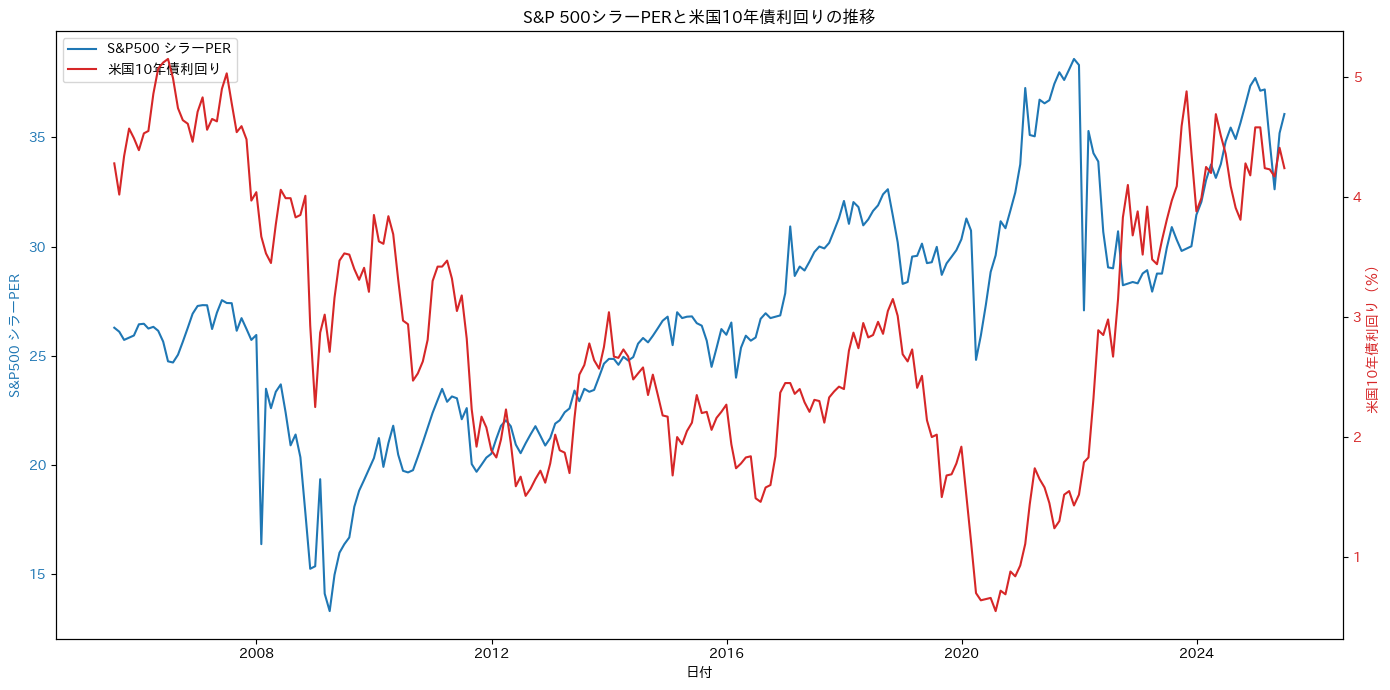

In [ ]:
#%% データの可視化

plt.figure(figsize=(14, 7))
fig, ax1 = plt.subplots(figsize=(14, 7))

# 左Y軸: S&P500のシラーPER
color = 'tab:blue'
ax1.set_xlabel('日付')
ax1.set_ylabel('S&P500 シラーPER', color=color)
l1 = ax1.plot(result_df.index, result_df['SP500_ShillerPER'], color=color, label='S&P500 シラーPER')
ax1.tick_params(axis='y', labelcolor=color)

# 右Y軸: 米国10年債利回り
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('米国10年債利回り（％）', color=color)
l2 = ax2.plot(result_df.index, result_df['US10Y_Rate'], color=color, label='米国10年債利回り')
ax2.tick_params(axis='y', labelcolor=color)

# タイトルと凡例
plt.title('S&P 500シラーPERと米国10年債利回りの推移')
lns = l1 + l2
labels = [l.get_label() for l in lns]
ax1.legend(lns, labels, loc='upper left')

plt.tight_layout()
plt.show()



 ## 5. 定量的分析：仮説の厳密な検証

 視覚的な印象を、客観的な数値データで厳密に検証する。

 ### 5-1. 散布図と相関係数
 散布図は、2つの変数の関係性をより直接的に示す。以下のグラフでは、点群が明確なパターンを描いておらず、回帰直線もほぼ水平に近い。これは、両者の間に強い線形関係がないことを強く示唆している。

 実際に計算した**相関係数は-0.036**であり、統計的には**「無相関」**と判断できるレベルである。

 ### 5-2. OLS回帰分析
 さらに、金利を説明変数、シラーPERを目的変数とする単回帰分析を行うことで、この関係性をモデル化する。

 **【回帰分析結果の読み解き】**
 - **R-squared (決定係数): 0.001**
   この値は、このモデル（金利）がシラーPERの変動の**わずか0.1%**しか説明できていないことを意味する。モデルとして、予測能力は皆無に等しい。
 - **P>|t| (P値): 0.578**
   金利の係数に対するP値が0.05を遥かに上回っている。これは、「金利とPERの間に関係があるように見えても、それは統計的に見て偶然である可能性が高い」ことを示している。

 **以上の定量的分析から、当初の「金利は株価の重力である」という仮説は、少なくともこの期間と分析手法においては、データによって支持されない（棄却される）。**

10年債利回りとS&P500シラーPERの相関係数: -0.036


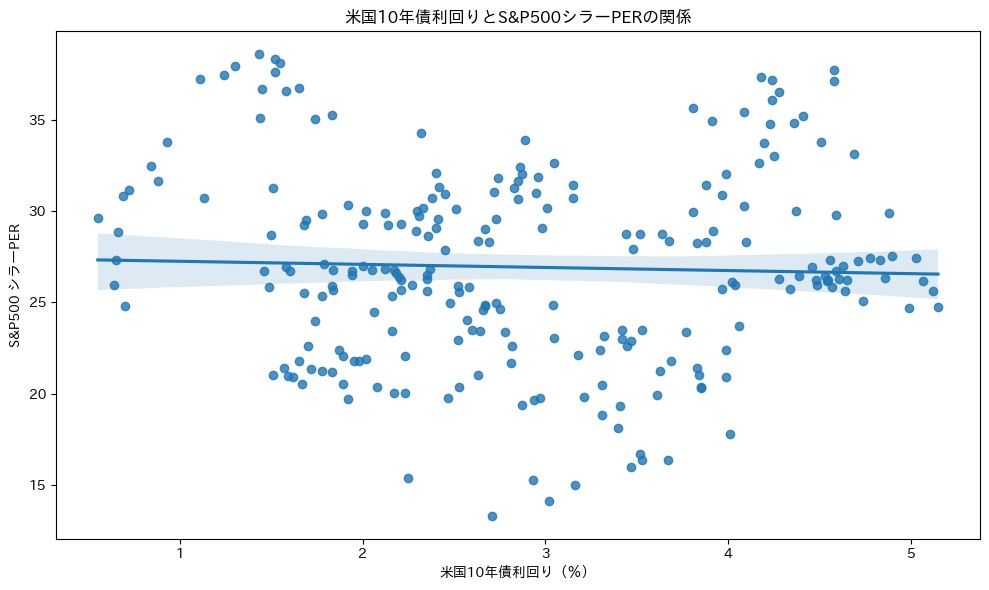

                            OLS Regression Results                            
Dep. Variable:       SP500_ShillerPER   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.3098
Date:                Fri, 04 Jul 2025   Prob (F-statistic):              0.578
Time:                        08:58:33   Log-Likelihood:                -740.46
No. Observations:                 240   AIC:                             1485.
Df Residuals:                     238   BIC:                             1492.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     27.4197      0.942     29.093      0.0

In [ ]:
#%% 相関分析と回帰分析

# 相関係数の計算
corr = result_df['US10Y_Rate'].corr(result_df['SP500_ShillerPER'])
print(f'10年債利回りとS&P500シラーPERの相関係数: {corr:.3f}')
# 通常、金利とPERは負の相関が期待されます（＝金利が上がるとPERは下がりやすい）

# 散布図と回帰直線
plt.figure(figsize=(10, 6))
sns.regplot(x='US10Y_Rate', y='SP500_ShillerPER', data=result_df)
plt.xlabel('米国10年債利回り（％）')
plt.ylabel('S&P500 シラーPER')
plt.title('米国10年債利回りとS&P500シラーPERの関係')
plt.tight_layout()
plt.show()

# 単回帰分析
model = smf.ols('SP500_ShillerPER ~ US10Y_Rate', data=result_df)
result = model.fit()
print(result.summary())



 ## 6. 理論モデルとの乖離：市場の"過熱"と"冷静"

 最後に、回帰分析の結果から導き出される「理論PER」（金利水準だけで説明されるPER）と、実際のPERを比較する。

 **【グラフの読み解き】**
 - **理論PER（赤の破線）**は、金利の影響が非常に小さいため、ほぼ横ばいの直線となっている。
 - **実際のPER（青線）**がこの理論PERを大きく上回っている時期（例: 2020年以降の金融緩和局面）は、**金利以外の要因（例: 熱狂的な成長期待）によって市場が「過熱」していた**可能性を示唆する。
 - 逆に、実際のPERが理論PERを下回っている時期（例: 2008年のリーマンショック後）は、**市場が過度に悲観的になっていた「割安」な局面**であったと解釈できる。

 この乖離の分析は、市場のセンチメント（投資家心理）を測るための一つのツールとなり得る。

<ipython-input-10-5d02f413240e>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = result.params[0]
<ipython-input-10-5d02f413240e>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = result.params[1]


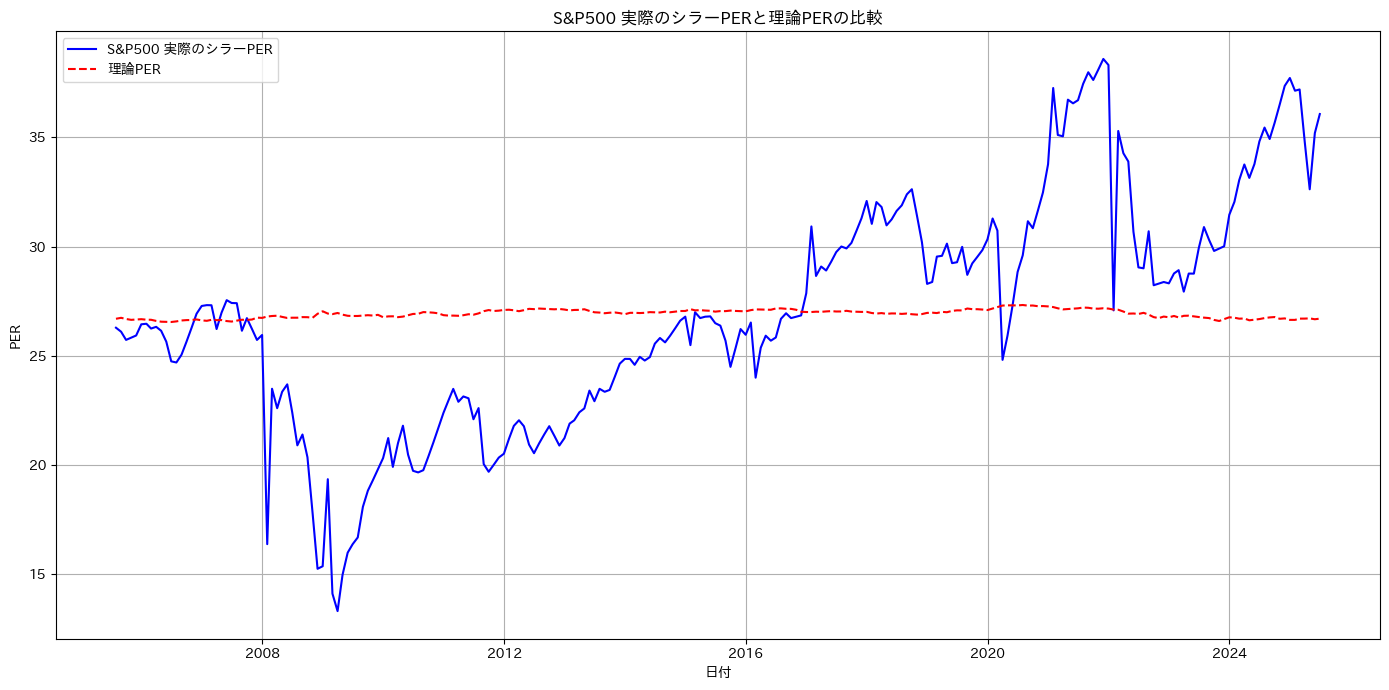

In [ ]:
#%% 理論PERとの比較

# 回帰モデルの係数を取得
intercept = result.params[0]
slope = result.params[1]

# 理論PERの計算
result_df['Theoretical_PER'] = intercept + slope * result_df['US10Y_Rate']

# 実際のPERと理論PERの比較グラフ
plt.figure(figsize=(14, 7))
plt.plot(result_df.index, result_df['SP500_ShillerPER'], label='S&P500 実際のシラーPER', color='blue')
plt.plot(result_df.index, result_df['Theoretical_PER'], label='理論PER', color='red', linestyle='--')
plt.xlabel('日付')
plt.ylabel('PER')
plt.title('S&P500 実際のシラーPERと理論PERの比較')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()